<a href="https://colab.research.google.com/github/yuval0978/Tiny_Mlp/blob/main/PID_Tiny_Mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this code is using only math - no high end libs like TF or Keras, so it could be used in micropython and MCU such as jetson nano or raspberry pi

#inits and running first test

In [ ]:
import math
import time
import numpy as np

DT = 0.005
T_TOTAL = 10.0
STEPS = int(T_TOTAL / DT)

class SimpleDCMotor: #simulation of a motor, using only math
	def __init__(self, J=0.01, b=0.1, Kt=0.1, max_u=12.0):
		self.J = J; self.b = b; self.Kt = Kt; self.max_u = max_u
		self.theta = 0.0; self.omega = 0.0
	def step(self, u, dt):
		u = float(np.clip(u, -self.max_u, self.max_u))
		torque = self.Kt * u
		omega_dot = (torque - self.b * self.omega) / self.J
		self.omega += omega_dot * dt
		self.theta += self.omega * dt
		return self.theta, self.omega

class PIDController: #simulates the PID for later use
	def __init__(self, Kp=8.0, Ki=0.5, Kd=0.2, integral_limit=100.0):
		self.Kp = float(Kp); self.Ki = float(Ki); self.Kd = float(Kd)
		self.integral = 0.0; self.last_e = 0.0
		self.integral_limit = integral_limit
	def reset(self):
		self.integral = 0.0; self.last_e = 0.0
	def compute(self, e, dt):
		self.integral += e * dt
		if self.integral > self.integral_limit: self.integral = self.integral_limit
		if self.integral < -self.integral_limit: self.integral = -self.integral_limit
		deriv = (e - self.last_e) / (dt if dt>0 else 1e-8)
		self.last_e = e
		u = self.Kp * e + self.Ki * self.integral + self.Kd * deriv
		return u

class TinyMLP: # creates a very small MLP (neural network) with vector as input and PID as output
	def __init__(self, input_dim=10, hidden=48, out_dim=3, seed=0):
		rng = np.random.RandomState(seed)
		self.w1 = rng.randn(hidden, input_dim) * 0.1
		self.b1 = np.zeros((hidden,))
		self.w2 = rng.randn(out_dim, hidden) * 0.1
		self.b2 = np.zeros((out_dim,))
	def forward(self, x):
		z1 = self.w1.dot(x) + self.b1
		a1 = np.maximum(z1, 0.0)
		z2 = self.w2.dot(a1) + self.b2
		self._x = x; self._z1 = z1; self._a1 = a1; self._z2 = z2
		return z2.copy()
	def backward_from_dout(self, dL_dout):
		self.dw2 = np.outer(dL_dout, self._a1)
		self.db2 = dL_dout.copy()
		da1 = self.w2.T.dot(dL_dout)
		dz1 = da1 * (self._z1 > 0).astype(float)
		self.dw1 = np.outer(dz1, self._x)
		self.db1 = dz1.copy()
	def step_sgd(self, lr=1e-4, clip=1.0):
		for g in [self.dw1, self.dw2, self.db1, self.db2]:
			norm = np.linalg.norm(g)
			if norm > clip and norm>0:
				g *= (clip / norm)
		self.w1 -= lr * self.dw1; self.b1 -= lr * self.db1
		self.w2 -= lr * self.dw2; self.b2 -= lr * self.db2

def build_feature_vector(e_hist, integral, u_hist, sp, noise_est=0.0, env_flag=0.0): #builds vector for input
	return np.array([
		e_hist[0], e_hist[1], e_hist[2],
		integral, (e_hist[0]-e_hist[1]),
		u_hist[0], u_hist[1],
		sp, noise_est, env_flag
	], dtype=np.float32)

#calling all classes
np.random.seed(0)
motor = SimpleDCMotor(J=0.01, b=0.15, Kt=0.2, max_u=12.0)
pid = PIDController(Kp=12.0, Ki=0.8, Kd=0.25, integral_limit=100.0)
mlp = TinyMLP(input_dim=10, hidden=48, out_dim=3, seed=1)

#learning rate and clip (for stabilizing the models)
LR = 0.10
CLIP = 0.03

times = []; errors = []
kp_log = []; ki_log = []; kd_log = []
u_log = []; theta_log = []; omega_log = []

motor.theta = 0.0; motor.omega = 0.0; pid.reset()
e_hist = [0.0,0.0,0.0]; u_hist = [0.0,0.0]
sp = 1.0; noise = 0.0

#main function
for step in range(STEPS):
	t = step * DT
	times.append(t)
	theta = motor.theta; omega = motor.omega
	e = sp - theta
	feat = build_feature_vector(e_hist, pid.integral, u_hist, sp, noise, 0.0)
	out = mlp.forward(feat)
	scale = 2.0 if abs(e) > 0.5 else max(0.2, 1.0 - abs(e))
	out = out * scale
	new_gains = np.array([pid.Kp + out[0], pid.Ki + out[1], pid.Kd + out[2]], dtype=float)
	new_gains[0] = float(np.clip(new_gains[0], 0.0, 80.0))
	new_gains[1] = float(np.clip(new_gains[1], 0.0, 15.0))
	new_gains[2] = float(np.clip(new_gains[2], 0.0, 8.0))
	pid.Kp, pid.Ki, pid.Kd = new_gains[0], new_gains[1], new_gains[2]
	u = pid.compute(e, DT)
	theta, omega = motor.step(u, DT)
	e_next = sp - theta
	errors.append(e)
	kp_log.append(pid.Kp); ki_log.append(pid.Ki); kd_log.append(pid.Kd)
	u_log.append(u); theta_log.append(theta); omega_log.append(omega)

	dL_dout = -e * out
	mlp.backward_from_dout(dL_dout)
	mlp.step_sgd(lr=LR, clip=CLIP)

	e_hist = [e] + e_hist[:2]
	u_hist = [u] + u_hist[:1]
	if abs(e) > 100:
		pid.integral = 0.0; pid.Kp = 12.0; pid.Ki = 0.8; pid.Kd = 0.25

#saving the model for later use
np.savez_compressed('pid_ai_sim_logs.npz',
	times=np.array(times), errors=np.array(errors),
	kp=np.array(kp_log), ki=np.array(ki_log), kd=np.array(kd_log),
	u=np.array(u_log), theta=np.array(theta_log), omega=np.array(omega_log))
print("Simulation complete. Logs saved to pid_ai_sim_logs.npz")

Simulation complete. Logs saved to pid_ai_sim_logs.npz


#graphs of first run

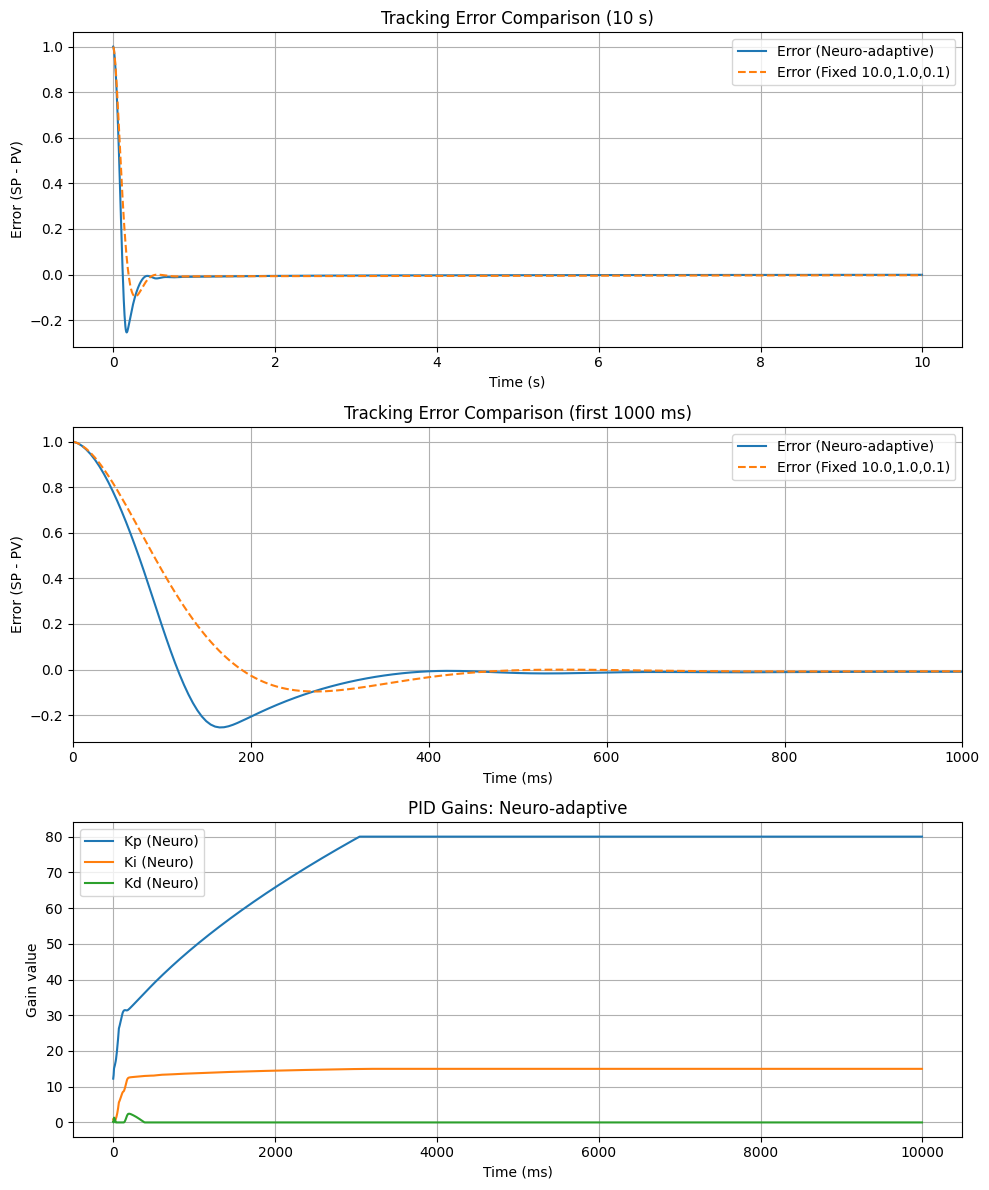

In [ ]:
import matplotlib.pyplot as plt

Kp_fixed = 10.0; Ki_fixed = 1.0; Kd_fixed = 0.1
motor_fixed = SimpleDCMotor(J=motor.J, b=motor.b, Kt=motor.Kt, max_u=motor.max_u)
pid_fixed = PIDController(Kp=Kp_fixed, Ki=Ki_fixed, Kd=Kd_fixed, integral_limit=100.0)
theta_fixed = 0.0; omega_fixed = 0.0
pid_fixed.reset()
errors_fixed = []
for _ in times:
	e_fixed = sp - theta_fixed
	u_fixed = pid_fixed.compute(e_fixed, DT)
	theta_fixed, omega_fixed = motor_fixed.step(u_fixed, DT)
	errors_fixed.append(e_fixed)

cut_idx = int(2.0 / DT)  # first 2 seconds

fig, axs = plt.subplots(3,1,figsize=(10,12))

# Full 10 s error comparison
axs[0].plot(times, errors, label='Error (Neuro-adaptive)')
axs[0].plot(times, errors_fixed, '--', label=f'Error (Fixed {Kp_fixed},{Ki_fixed},{Kd_fixed})')
axs[0].set_title("Tracking Error Comparison (10 s)")
axs[0].set_xlabel("Time (s)"); axs[0].set_ylabel("Error (SP - PV)")
axs[0].legend(); axs[0].grid(True)

# Zoomed-in first 1000 ms
axs[1].plot(np.array(times[:cut_idx])*1000, errors[:cut_idx], label='Error (Neuro-adaptive)')
axs[1].plot(np.array(times[:cut_idx])*1000, errors_fixed[:cut_idx], '--', label=f'Error (Fixed {Kp_fixed},{Ki_fixed},{Kd_fixed})')
axs[1].set_xlim(0, 1000)
axs[1].set_title("Tracking Error Comparison (first 1000 ms)")
axs[1].set_xlabel("Time (ms)"); axs[1].set_ylabel("Error (SP - PV)")
axs[1].legend(); axs[1].grid(True)

# PID gains
axs[2].plot(np.array(times)*1000, kp_log, label='Kp (Neuro)')
axs[2].plot(np.array(times)*1000, ki_log, label='Ki (Neuro)')
axs[2].plot(np.array(times)*1000, kd_log, label='Kd (Neuro)')
axs[2].set_title("PID Gains: Neuro-adaptive")
axs[2].set_xlabel("Time (ms)"); axs[2].set_ylabel("Gain value")
axs[2].legend(); axs[2].grid(True)

plt.tight_layout(); plt.show()

#few more simulations of different motors and their graphs

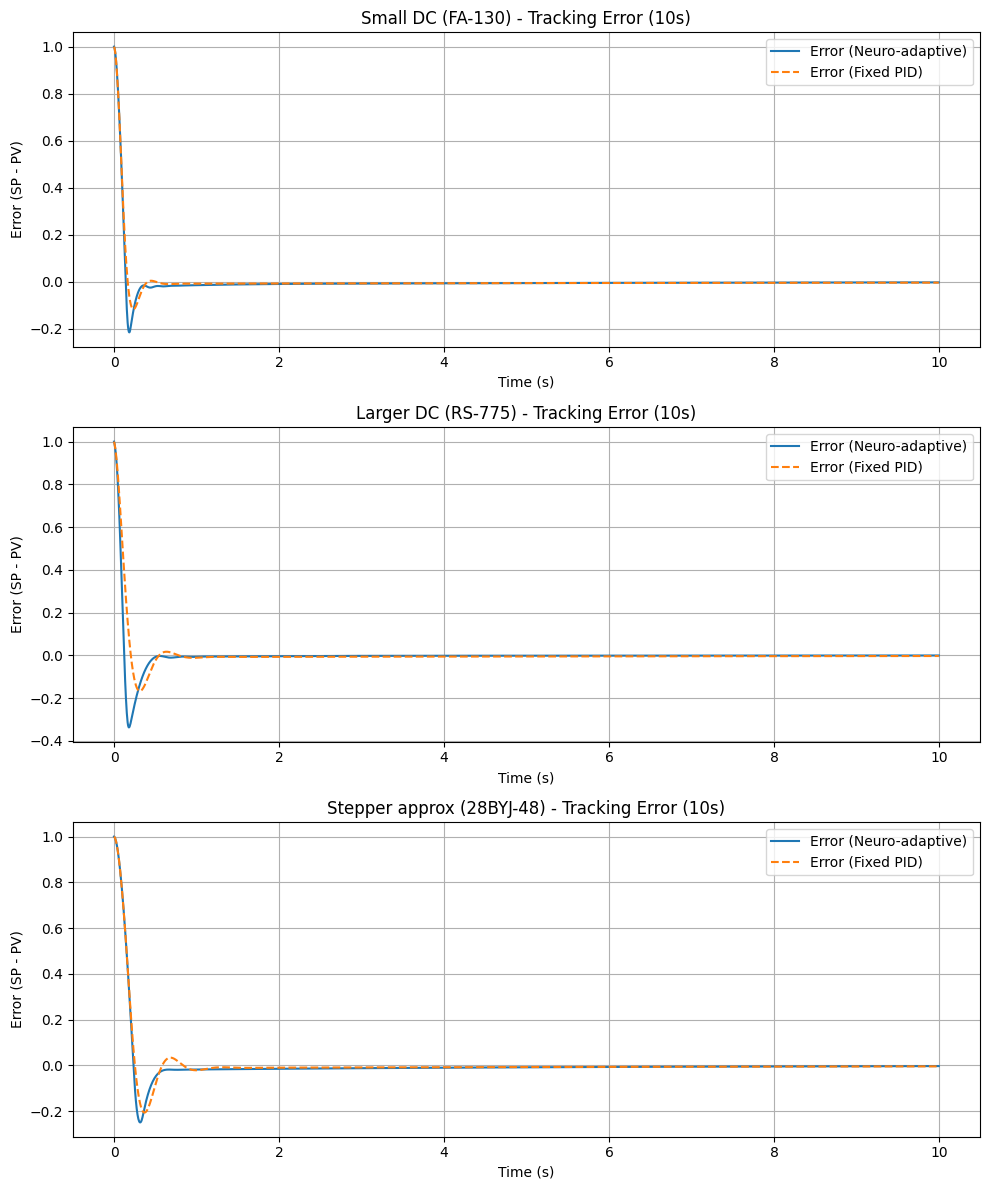

In [ ]:
motors = { #dict of approxamtions of diffrent motors and their step func
	"Small DC (FA-130)": (0.005,0.08,0.15,6.0),
	"Larger DC (RS-775)": (0.02,0.2,0.25,24.0),
	"Stepper approx (28BYJ-48)": (0.015,0.12,0.18,5.0)
}

def run_sim(motor_params, Kp_fixed=10.0, Ki_fixed=1.0, Kd_fixed=0.1): #function of running the sim
	np.random.seed(0)
	motor = SimpleDCMotor(*motor_params)
	pid = PIDController(Kp=12.0, Ki=0.8, Kd=0.25)
	mlp = TinyMLP(seed=1)
	LR, CLIP = 0.1, 0.03
	times=[]; errors=[]; e_hist=[0,0,0]; u_hist=[0,0]; sp=1.0
	for step in range(STEPS):
		t = step*DT; times.append(t)
		e = sp - motor.theta
		feat = build_feature_vector(e_hist, pid.integral, u_hist, sp)
		out = mlp.forward(feat)
		scale = 2.0 if abs(e)>0.5 else max(0.2,1.0-abs(e))
		out = out*scale
		new_gains = np.array([pid.Kp+out[0], pid.Ki+out[1], pid.Kd+out[2]])
		new_gains[0]=np.clip(new_gains[0],0,80); new_gains[1]=np.clip(new_gains[1],0,15); new_gains[2]=np.clip(new_gains[2],0,8)
		pid.Kp, pid.Ki, pid.Kd = new_gains
		u = pid.compute(e,DT)
		motor.step(u,DT)
		errors.append(e)
		dL_dout = -e*out; mlp.backward_from_dout(dL_dout); mlp.step_sgd(lr=LR,clip=CLIP)
		e_hist=[e]+e_hist[:2]; u_hist=[u]+u_hist[:1]

	# Fixed PID baseline
	motor_fixed = SimpleDCMotor(*motor_params)
	pid_fixed = PIDController(Kp=Kp_fixed, Ki=Ki_fixed, Kd=Kd_fixed)
	errors_fixed=[]; pid_fixed.reset()
	for _ in times:
		e = sp - motor_fixed.theta
		u = pid_fixed.compute(e,DT)
		motor_fixed.step(u,DT)
		errors_fixed.append(e)
	return times, errors, errors_fixed

fig, axs = plt.subplots(len(motors),1,figsize=(10,12))
for i,(name,params) in enumerate(motors.items()):
	times, err, err_fixed = run_sim(params)
	axs[i].plot(times, err, label="Error (Neuro-adaptive)")
	axs[i].plot(times, err_fixed, "--", label="Error (Fixed PID)")
	axs[i].set_title(f"{name} - Tracking Error (10s)")
	axs[i].set_xlabel("Time (s)"); axs[i].set_ylabel("Error (SP - PV)")
	axs[i].legend(); axs[i].grid(True)
plt.tight_layout(); plt.show()